**Лабораторная № 0. Пчелкина Ю.Ж. Перемножение матриц**

Задача

Входные данные: 2 матрицы размером от 100х100 до 2000х2000 каждая.

Выходные данные: проверка корректности перемножения + время вычисления

Реализация должна содержать 2 функции перемножения матриц: на CPU и на GPU с
применением CUDA.

Отчет о проделанной лабораторной работе - это git-репозиторий с исходным кодом
реализации + описание проделанной работы там же в readme.

Необходимо описать реализацию, объяснив, что конкретно было распараллелено и
почему.

Провести эксперименты: перемножить матрицы разных размеров, посчитать
ускорение. 

Результаты привести в виде таблицы/графика.


In [ ]:
import math
import random

import numpy as np
from numba import cuda, int32
from tabulate import tabulate

import time
import datetime

import matplotlib.pyplot as plt



In [ ]:
# Расчет будет производиться на блоках элементов TPBxTPB
TPB = 16
# Количество итераций для вычисления среднего затраченного времени
ITER_COUNT = 10

#### функция для создания матриц одного размера MxM

In [ ]:
def mat_create1 (M):
  z1 = []
  z2 = []
  for x in range (M):
    for y in range (M):
      # заполняем два массива размером М*М числами от 1 до 9
      z1.append(int32(random.randint(0., 9.)))  
      z2.append(int32(random.randint(0., 9.)))
      A = np.array(z1)
      B = np.array(z2)
  #преобразем массивы в матрицы
  A = A.reshape(M, M) 
  B = B.reshape(M, M)
  # матрица из нулей (для результатов)
  C = np.zeros((M, M), dtype=np.int32)
  return (A, B, C)



In [ ]:
def mat_create (M):
  A = np.random.randint(1000, size=(M,M))
  B = np.random.randint(1000, size=(M,M))
  C = np.zeros((M, M), dtype=np.int32)
  return (A, B, C)



In [ ]:
M = 100
A, B, C = mat_create (M)

#### Умножение матриц с использованием служебной функции (на CPU)

In [ ]:
# отметили стартовое время
start_time = datetime.datetime.now() 
C1 = A.dot(B)
# посчитали затраченное время
t1 = datetime.datetime.now() - start_time
print(C1)
print ('time:  '+ str(t1)) 

[[19528574 18843103 17967016 ... 19553708 20827827 20881123]
 [24124412 24688987 23692978 ... 24956381 25707937 25866331]
 [24723328 24789117 24592620 ... 26336016 25802056 27860384]
 ...
 [21597252 23126633 20883585 ... 23397029 22991319 25878520]
 [22920864 23066480 21227686 ... 25531096 23697302 24606699]
 [23675668 26334828 24896930 ... 27622698 27584911 28848563]]
time:  0:00:00.002392


#### Собственная реализация функции для умножения матриц  (на CPU)

In [ ]:
def mat_mul_CPU (matr1, matr2, matr3, M):
    
    for i in range(0, M):
        for j in range(0, M):
            for k in range(0, M):
                matr3[i][j] += int(matr1[i][k] * matr2[k][j])  
    
    return (matr3)

проверка

In [ ]:
# отметили стартовое время    
start_time = datetime.datetime.now()    
C2 = mat_mul_CPU(A, B, C, M)
# посчитали затраченное время
t2 = datetime.datetime.now() - start_time

print(C2)
print ('time:  '+ str(t2))     


[[19528574 18843103 17967016 ... 19553708 20827827 20881123]
 [24124412 24688987 23692978 ... 24956381 25707937 25866331]
 [24723328 24789117 24592620 ... 26336016 25802056 27860384]
 ...
 [21597252 23126633 20883585 ... 23397029 22991319 25878520]
 [22920864 23066480 21227686 ... 25531096 23697302 24606699]
 [23675668 26334828 24896930 ... 27622698 27584911 28848563]]
time:  0:00:04.057755


#### Функция для для умножения матриц (на GPU с применением CUDA)


Данная функция выполняет умножение квадратных матриц на GPU.

Результирующая матрица состоит из квадрадных "подмариц", вычисление каждой такой "подматрицы" отведено отдельному блоку потоков.

Используется преимущество быстрой общей памяти и сохраняется большая пропускная способность глобальной памяти. 

In [ ]:
#Динамический компилятор Cuda
@cuda.jit
def mat_mul_GPU(d_a, d_b, d_c):
  # определяем массив в общей памяти
  shared_a = cuda.shared.array(shape=(TPB, TPB), dtype=int32)
  shared_b = cuda.shared.array(shape=(TPB, TPB), dtype=int32)

  x, y = cuda.grid(2)
  
  # Набор встроенных функций CUDA используется для идентификации текущего потока выполнения, имеют смысл только внутри ядра CUDA или функции устройства
  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y
  # количество блоков на сетку
  bpg = cuda.gridDim.x  

  # проверяем, что не вышли за границы
  if x >= d_c.shape[0] and y >= d_c.shape[1]:
    return

  # каждый поток вычисляет один элемент в итоговой матрице, произведение разбивается на произведения векторов длиной TPB
  tmp = 0.
  for i in range(bpg):
    # загружаем данные в общую память
    shared_a[tx, ty] = d_a[x, ty + i * TPB]
    shared_b[tx, ty] = d_b[tx + i * TPB, y]

    # ожидание окончания предварительной загрузки
    cuda.syncthreads() 
    
    # вычисление в общей памяти
    for j in range(TPB):
      tmp += shared_a[tx, j] * shared_b[j, ty]

    # Ожидание окончания вычисления на всех потоках
    cuda.syncthreads()   
  d_c[x, y] = tmp


проверка

In [ ]:
    
grid_size = (10, 10)
block_size = (16, 16)
# отметили стартовое время
start_time = datetime.datetime.now()    

# Перенос данных в глобальную память GPU
d_a = cuda.to_device(A)
d_b = cuda.to_device(B)
d_c = cuda.to_device(C)

# вызов ядра
mat_mul_GPU[grid_size, block_size](d_a, d_b, d_c)
# Перенос вывода с устройства на хост
C3 = d_c.copy_to_host()

# посчитали затраченное время
t3 = datetime.datetime.now() - start_time

print(C3)
print ('time:  '+ str(t3))

[[19528574 18843103 17967016 ... 19553708 20827827 20881123]
 [24124412 24688987 23692978 ... 24956381 25707937 25866331]
 [24723328 24789117 24592620 ... 26336016 25802056 27860384]
 ...
 [21597252 23126633 20883585 ... 23397029 22991319 25878520]
 [22920864 23066480 21227686 ... 25531096 23697302 24606699]
 [23675668 26334828 24896930 ... 27622698 27584911 28848563]]
time:  0:00:00.007048


#### Сравниваем два метода : встроенную функцию dot (на CPU) и функцию mat_mul_GPU (для расчетов на GPU). 

Функция mat_mul_CPU реализует умножение матриц за значительно большее время, поэтому при сравнении не учитывалась.

Для разных размеров матриц (от 112х112 до 2000х2000) проверяем среднее время выполнения для 10 итераций


In [ ]:

result_list = []
# размер матриц по условию от 100x100 до 2000х2000, 
# расчет производится на блоках элементов TPBxTPB (т.е. 16x16)
# Количество итераций для вычисления среднего затраченного времени ITER_COUNT = 10

for bpg in range(6, 125, 10):
  grid_size = (bpg, bpg)
  block_size = (TPB, TPB)
  
  # размер матрицы
  M = bpg * TPB
  #mat_size = (bpg * TPB, bpg * TPB)

  correct_result = True
  
  dot_time_sum = 0
  cpu_time_sum = 0
  gpu_time_sum = 0

  for _ in range(ITER_COUNT):
    # создаем матрицы размера М
    A, B, C = mat_create (M)
   
    # отметили стартовое время
    start = time.time()
    C1 = A.dot(B)
    # считаем затраченное время
    dot_time = time.time() - start
    dot_time_sum += dot_time

    # отметили стартовое время
    #start = time.time()
    #C2 = mat_mul_CPU(A, B, C, M)
    # считаем затраченное время
    #cpu_time = time.time() - start
    #cpu_time_sum += cpu_time


    # отметили стартовое время
    start = time.time()
    # Перенос данных в глобальную память GPU
    d_a = cuda.to_device(A)
    d_b = cuda.to_device(B)
    d_c = cuda.to_device(C)
    # вызов ядра
    mat_mul_GPU[grid_size, block_size](d_a, d_b, d_c)
    # Перенос вывода с устройства на хост
    C3 = d_c.copy_to_host()
    # считаем затраченное время
    gpu_time = time.time() - start
    gpu_time_sum += gpu_time

    # для проверки правильности вычислений на GPU
    correct_result = np.array_equal(C3, C1)

  res = [M, correct_result, dot_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
  #print(res)
  result_list.append(res)


In [ ]:
print(tabulate(result_list, headers=['matrix size', 'correct', 'cpu time', 'gpu time']))

  matrix size  correct      cpu time    gpu time
-------------  ---------  ----------  ----------
           96  True       0.00012002  0.00465629
          256  True       0.00554235  0.00416636
          416  True       0.0118726   0.00716889
          576  True       0.0521146   0.0129493
          736  True       0.118225    0.023291
          896  True       0.203405    0.039026
         1056  True       0.430188    0.0612729
         1216  True       0.572019    0.0912374
         1376  True       0.687808    0.120546
         1536  True       0.998136    0.158086
         1696  True       1.36846     0.213716
         1856  True       1.89626     0.274552


### Выводы.
1. Вычисления на GPU верны
2. Вычисления на GPU в основном затрачивают меньше времени (особенно при работе с матрицами больших размерностей)

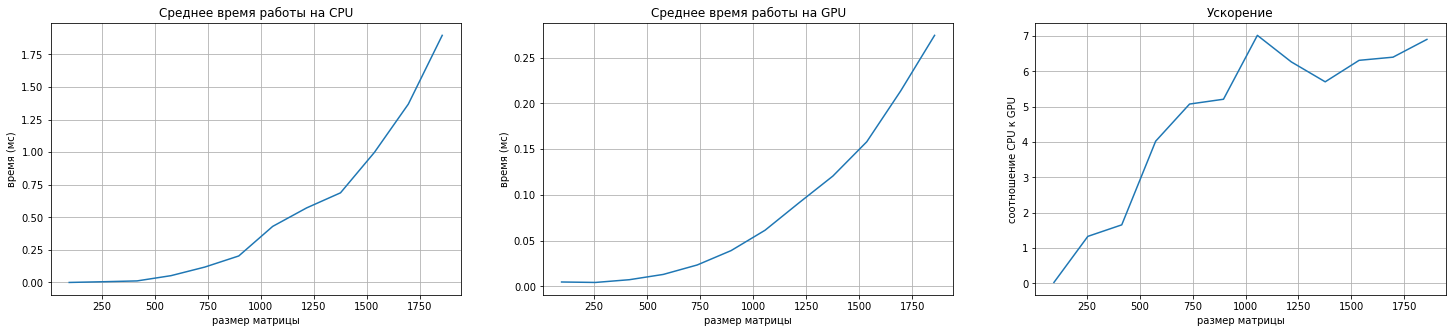

In [ ]:
result_matr = np.array(result_list)
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.title('Среднее время работы на CPU')
plt.plot(result_matr[:, 0], result_matr[:, 2])
plt.xlabel('размер матрицы')
plt.ylabel('время (мс)')
plt.grid()

plt.subplot(1, 3, 2)
plt.title('Среднее время работы на GPU')
plt.plot(result_matr[:, 0], result_matr[:, 3])
plt.xlabel('размер матрицы')
plt.ylabel('время (мс)')
plt.grid()

plt.subplot(1, 3, 3)
plt.title('Ускорение')
plt.plot(result_matr[:, 0], (result_matr[:, 2]/result_matr[:, 3]))
plt.xlabel('размер матрицы')
plt.ylabel('соотношение CPU к GPU')
plt.grid()

